# Generate population estimates and plots

Generates population estimates by day. Can use a subset of cameras to model different camera configurations.

In [1]:
import glob
import os
import random

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import seaborn as sns
from sklearn.neighbors import KernelDensity
import utm

import bat_functions as bf

In [2]:
# Where to save count data that is produced
save_data_folder = '.../Documents/bat-data/counts'
os.makedirs(save_data_folder, exist_ok=True)

# Where to save plots that are produced
save_plot_folder = '.../Documents/bat-data/plots/population-estimates'
os.makedirs(save_plot_folder, exist_ok=True)

### Load observation information

In [3]:
# Change to correct local path
# Dataverse folder has contents from 
# https://edmond.mpdl.mpg.de/dataset.xhtml?persistentId=doi:10.17617/3.1YIESH
observations_root = ".../Documents/bat-data/dataverse_files"

# Get dates of all observations in folder
all_files = sorted(glob.glob(os.path.join(observations_root, "*.npy")))
all_dates = [os.path.basename(f).split("-")[0] for f in all_files]
dates = sorted(list(set(all_dates)))

all_observations = {}

for date in dates:
    obs_files = sorted(glob.glob(os.path.join(observations_root, f'{date}*.npy')))
    all_observations[date] = {}
    for obs_file in obs_files:
        camera = os.path.splitext(obs_file)[0].split('-')[-1]
        obs = np.load(obs_file, allow_pickle=True)
        # using .item() to get dict from inside the array that 
        # was wrapped around it when using np.save()
        all_observations[date][camera] = obs.item()



### Remove observations to exclude (because camera ran out of batteries etc.)

In [4]:
exclude=True
# Manually exclude cameras that had issues
all_observations['17Nov']['MusoleParking']['exclude'] = True
all_observations['18Nov']['MusolePath']['exclude'] = True
all_observations['20Nov']['MusolePath']['exclude'] = True
if exclude:
    good_obs = {}
    for date, day_obs in all_observations.items():
        good_obs[date] = {}
        for camera, obs in day_obs.items():
            if 'exclude' in obs.keys():
                if obs['exclude']:
                    continue
            good_obs[date][camera] = obs
    all_observations = good_obs

### Information about the cameras and environment

In [5]:
shift = 48 # loss on each side from not padding during detection (48)
FRAME_WIDTH = 2704 - (2 * shift)
WINGSPAN = .8 # meters, max extent while flying 

# Coordinates of two possible forest center 
# Used if not sampling randomly from forest as defined bellow
center_utm = {'middle': np.array([200450, 8606950]),
              'right': np.array([200800, 8606900])}

camera_locations = {'FibweParking2': [-12.5903393, 30.2525047],	
                    'FibweParking': [-12.5903393, 30.2525047],
                    'Chyniangale': [-12.5851284, 30.245529],	
                    'BBC': [-12.5863538, 30.2484985],
                    'Sunset': [-12.585784, 30.240003],
                    'NotChyniangale': [-12.5849206,	30.2436135],
                    'MusoleParking': [-12.58787, 30.2401],	
                    'MusolePath2': [-12.589544,	30.242488],	
                    'MusolePath': [-12.589544,	30.242488],
                    'Puku': [-12.584838, 30.24137],	
                    'FibwePublic': [-12.592537, 30.2515924],	
                    'MusoleTower': [-12.589434, 30.244736],
                    }
all_camera_utms = bf.latlong_dict_to_utm(camera_locations)

# If vary_center is True then center locations are sampled from this shape
forest_border = [[-12.585957, 30.242762],
                 [-12.586763, 30.246229],
                 [-12.589182, 30.245566],
                 [-12.587557, 30.241598]
                ]

forest_utms = []
for f_latlon in forest_border:
    f_utm = utm.from_latlon(*f_latlon)
    forest_utms.append([f_utm[0], f_utm[1]])
forest_utms = np.array(forest_utms)

# map_file is a geotiff of the forest
map_file = "kasanka-utm.tiff"
forest_map_dataset = rasterio.open(map_file)
forest_map = [forest_map_dataset.read(band_ind) for band_ind in range(1, 4)]
forest_map = np.array(forest_map)
forest_map = forest_map.transpose(1, 2, 0)
width = np.abs(forest_map_dataset.bounds.left - forest_map_dataset.bounds.right).astype(int)
height = np.abs(forest_map_dataset.bounds.top - forest_map_dataset.bounds.bottom).astype(int)
area = np.zeros((height, width), dtype=np.uint8)

norm_forest = np.copy(forest_utms)
area_x_origin = forest_map_dataset.bounds.left
area_y_origin = forest_map_dataset.bounds.bottom
norm_forest[:, 0] = forest_utms[:, 0] - area_x_origin
norm_forest[:, 1] = forest_utms[:, 1] - area_y_origin
forest_mask = cv2.drawContours(area, 
                        [norm_forest.astype(np.int32)], 
                        -1, 255, -1)

### Load wingspan correction information (from previous human validation)

In [6]:
wing_validation_file = "combined_wing_validation_info.csv"
wing_correction_info = bf.get_wing_correction_distributions(wing_validation_file,
                                                            num_darkness_bins=4,
                                                            kde_bw_scale=.25,
                                                            should_plot=False
                                                           )
wing_correction_kdes, darkness_bins = wing_correction_info

### Generate and save population estimates for specified days from specified numbers of cameras and sampling regimes

In [11]:
# How many population estimates to get from each camera
replicates = 500

# If True, then pull a random coordinate from withing the defined forest
vary_center = True
# If True, vary where transition between neighboring camera densities occur
jitter = True
# If True, scale each wingspan by a value from the human validation distsributions
correct_wing = True

# parameters from linear piecewise function for darkness error correction
parameters = [[1.57454778e+01, 9.37398964e-01, 7.18914388e-02, -1.27575036e-04]]

# Which dates to get population estimates from
dates = ['16Nov', '17Nov', '18Nov', '19Nov', '20Nov']

def pick_observations(camera_dict, num_cameras):
    """ Randomly select num_cameras from camera_dict
     set num_cameras to -1 to return unchanged camera_dict"""
    if num_cameras == -1:
        return camera_dict
    keys = random.sample(camera_dict.keys(), num_cameras)
    new_dict = {}
    for k in keys:
        new_dict[k] = camera_dict[k]
    return new_dict

# How many cameras to use for the population estimate (-1 means all cameras)
for num_cameras in [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    print(f"num cameras {num_cameras}")
    trial_dicts = []
    for date in dates:
        for _ in range(replicates):
            if vary_center:
                center = bf.get_random_utm_in_mask(forest_mask, 
                                                   forest_map_dataset)
            else:
                # Whatever chosen fixed center location is
                center = center_utm['middle']

            trial_dict = {'date': date,
                          'observations': pick_observations(
                              all_observations[date], num_cameras),
                          'center': center,
                          'dark_parameters': parameters[0],
                          'jitter': jitter,
                          'correct_wing': correct_wing,
                          'accumulation': None,
                          'camera_fractions': None
                         }

            trial_dicts.append(trial_dict)


    day_plots = {}
    day_totals = {}
    for date in dates:
        day_totals[date] = []

    for trial_num, trial_dict in enumerate(trial_dicts):
        if trial_num % 500 == 0:
            print(f'trial num {trial_num} starting...')

        observations = trial_dict['observations']
        date = trial_dict['date']
        camera_utms = bf.get_camera_locations(observations, 
                                              all_camera_utms, 
                                              exclude=True)
        camera_distances = bf.get_camera_distances(camera_utms, 
                                                   trial_dict['center'])
        camera_fractions = bf.get_camera_fractions(camera_utms, 
                                                   trial_dict['center'],
                                                   trial_dict['jitter'])
        trial_dict['camera_fractions'] = camera_fractions

        dark_parameters = trial_dict['dark_parameters']

        day_total = 0
        trial_summary = {}
        for cam_ind, (cam_name, obs) in enumerate(observations.items()):

            assert len(obs['darkness']) == len(obs['mean_wing'])
            if trial_dict['correct_wing']:
                correction_scale, kde_inds = bf.get_kde_samples(obs, wing_correction_kdes, darkness_bins)
            else:
                correction_scale = 0

            biased_wing = bf.correct_wingspan(obs['mean_wing'], correction_scale)
            biased_wing = np.maximum(biased_wing, 2) # No wingspans smaller than 2 pixels
            obs['multiplier'] = bf.combined_bat_multiplier(FRAME_WIDTH, 
                                                           WINGSPAN, 
                                                           biased_wing, 
                                                           camera_distances[obs['camera']]
                                                          )
            obs['fraction_total'] = camera_fractions[obs['camera']]
            bat_accumulation = bf.get_bat_accumulation(obs['frames'], obs, dark_parameters)
            trial_summary[cam_name] = bat_accumulation[-1]


            day_total += bat_accumulation[-1]

        day_totals[date].append(day_total)
        trial_summary['total'] = day_total
        trial_dict['accumulation'] = trial_summary
        
    if num_cameras == -1:
        num_cameras = 'all'
    count_file = f"num_cameras-{num_cameras}-jitter-{jitter}-vary_center-{vary_center}-correct_wing-{correct_wing}-replicates-{replicates}.npy"
    np.save(os.path.join(save_data_folder, count_file), day_totals)

num cameras -1
trial num 0 starting...
trial num 500 starting...
trial num 1000 starting...
trial num 1500 starting...
trial num 2000 starting...
num cameras 1


/var/folders/5g/z2s6xjx97xd45k2zvtq5yrgc0000gn/T/ipykernel_68654/2258932238.py:22: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  keys = random.sample(camera_dict.keys(), num_cameras)


trial num 0 starting...
trial num 500 starting...
trial num 1000 starting...
trial num 1500 starting...
trial num 2000 starting...
num cameras 2
trial num 0 starting...
trial num 500 starting...
trial num 1000 starting...
trial num 1500 starting...
trial num 2000 starting...
num cameras 3
trial num 0 starting...
trial num 500 starting...
trial num 1000 starting...
trial num 1500 starting...
trial num 2000 starting...
num cameras 4
trial num 0 starting...
trial num 500 starting...
trial num 1000 starting...
trial num 1500 starting...
trial num 2000 starting...
num cameras 5
trial num 0 starting...
trial num 500 starting...
trial num 1000 starting...
trial num 1500 starting...
trial num 2000 starting...
num cameras 6
trial num 0 starting...
trial num 500 starting...
trial num 1000 starting...
trial num 1500 starting...
trial num 2000 starting...
num cameras 7
trial num 0 starting...
trial num 500 starting...
trial num 1000 starting...
trial num 1500 starting...
trial num 2000 starting...

### Using counts generated above, plot the daily and combined population estimates
(Here, using the data from all the cameras)

mean average 886118.7298699957
min average 794099.9394947591
max average 1029919.1564815796


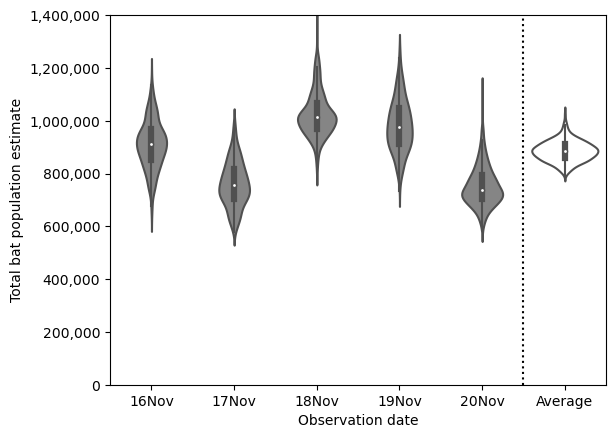

In [12]:
save_fig = False

num_cameras = 'all'
day_total_file = f"num_cameras-{num_cameras}-jitter-{jitter}-vary_center-{vary_center}-correct_wing-{correct_wing}-replicates-{replicates}.npy"
day_totals = np.load(os.path.join(save_data_folder, day_total_file), 
                     allow_pickle=True).item()

# These lists get fed to seaborn for plotting
all_totals = []
all_dates = []

# For plotting, add counts from each day
for day, totals in day_totals.items():
    all_dates.extend([day for _ in totals])
    all_totals.extend(totals)
      
# Get distribution of possible total population across days 
# Average one count from each day
replicates_mean = replicates
combined_estimates = []
for _ in range(replicates_mean):
    day_estimates = []
    for day, totals in day_totals.items():
        # k = 1 to pull single raw estimate for each day
        day_estimates.append(np.mean(random.choices(totals, k=1)))
    combined_estimates.append(np.mean(day_estimates))
print(f"mean average {np.mean(combined_estimates)}")   
print(f"min average {np.min(combined_estimates)}") 
print(f"max average {np.max(combined_estimates)}") 
all_dates.extend(['Average' for _ in combined_estimates])
all_totals.extend(combined_estimates)

# Make the actual plot
plt.figure()

# Colors for plotting
day_color = "#858585"
total_color = "#FFFFFF"

colors = [day_color for _ in range(5)]
colors.append(total_color)
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

sns.violinplot(x=all_dates, y=all_totals)
plt.ylabel('Total bat population estimate')
plt.xlabel('Observation date')
plt.axvline(4.5, c='k', linestyle=':')
plt.ylim(0, 1400000)
plt.ticklabel_format(style='plain', axis='y')
plt.gca().get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#     plt.title(f"num cameras: {num_cameras}, replicates {replicates}")
title = f"total count distribution violin {date} jitter {jitter} correct_wing {correct_wing} vary_center {vary_center} replicates {replicates}"
if save_fig:
    bf.save_fig(save_plot_folder, title)

### Plot daily count distributions from subsets of cameras
To investigate how many cameras are needed for counts to stabilize

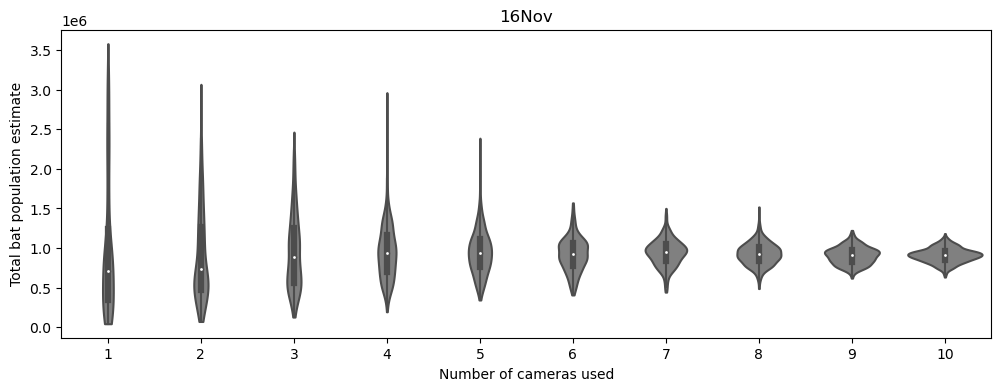

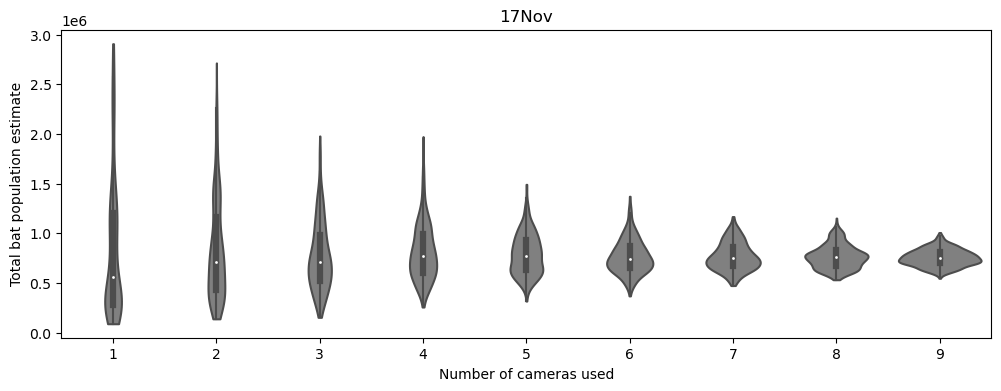

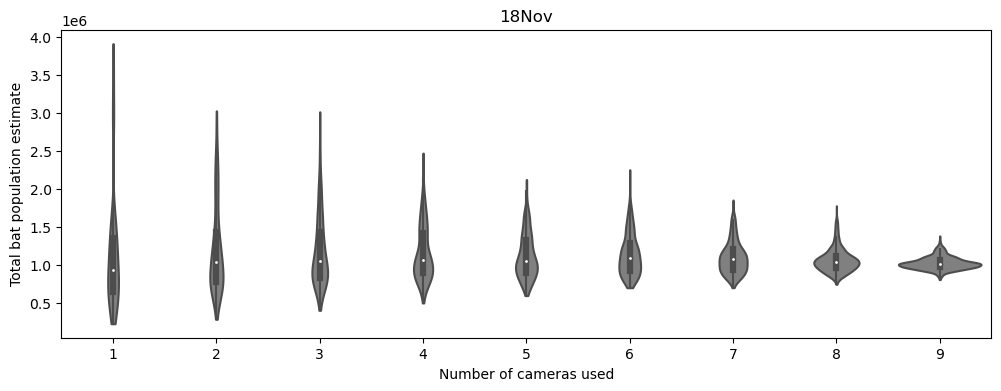

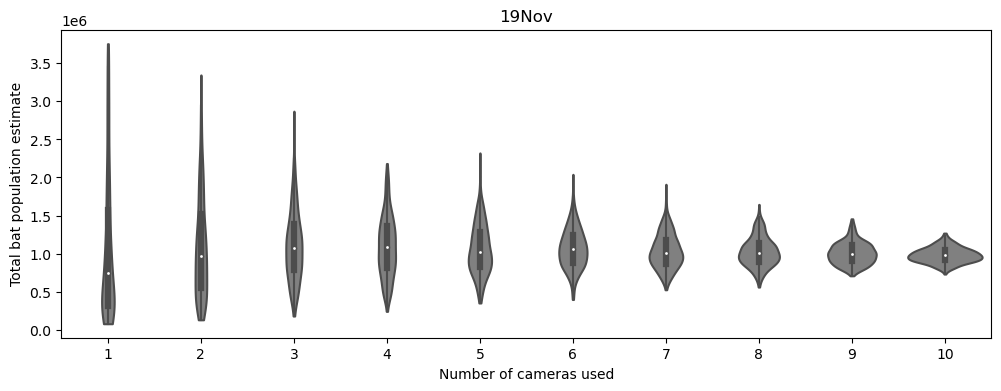

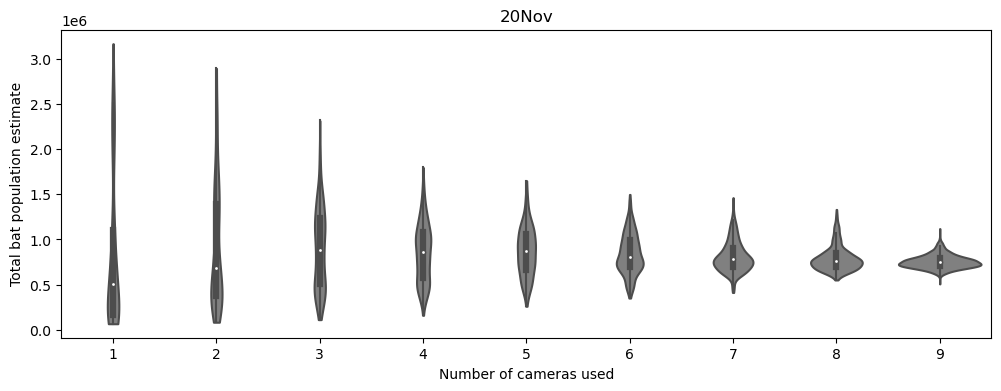

In [13]:
save_fig = False

for day in ['16Nov', '17Nov', '18Nov', '19Nov', '20Nov']:
    # These lists get fed to seaborn for plotting
    all_totals = []
    all_num_cameras = []
    for num_cameras in [1, 2, 3, 4, 5, 6, 7, 8, 9, 'all']:
        day_total_file = f"num_cameras-{num_cameras}-jitter-{jitter}-vary_center-{vary_center}-correct_wing-{correct_wing}-replicates-{replicates}.npy"
        day_totals = np.load(os.path.join(save_data_folder, day_total_file), 
                             allow_pickle=True).item()

        totals = day_totals[day]
        x_label = num_cameras
        if num_cameras == 'all':
            if day == '16Nov' or day == '19Nov':
                x_label = 10
            else:
                x_label = 9
        all_num_cameras.extend([x_label for _ in totals])
        all_totals.extend(totals)
    
    plt.figure(figsize=(12,4))

    sns.violinplot(x=all_num_cameras, y=all_totals, cut=0, color="gray")
    plt.ylabel('Total bat population estimate')
    plt.xlabel('Number of cameras used')
    plt.title(f"{day}")
    title = f"total count distribution violin varying camera num date {day} replicates {replicates}"
    if save_fig:
        bf.save_fig(save_plot_folder, title)